In [53]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import ExtraTreesClassifier

In [8]:

# importing metadata and checking for its shape

metadata = pd.read_csv('HAM10000_metadata.csv')
print(metadata.shape)

# label encoding the seven classes for skin cancers
le = LabelEncoder()
le.fit(metadata['dx'])
LabelEncoder()
print("Classes:", list(le.classes_))
 
metadata['label'] = le.transform(metadata["dx"]) 
metadata.sample(10)

(10015, 7)
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


,lesion_id,image_id,dx,dx_type,age,sex,localization,label
5499,HAM_0006405,ISIC_0031641,nv,follow_up,35.0,female,trunk,5
4795,HAM_0002252,ISIC_0031227,nv,follow_up,40.0,male,back,5
1602,HAM_0000388,ISIC_0032544,mel,histo,60.0,male,back,4
4381,HAM_0004649,ISIC_0031373,nv,follow_up,60.0,female,trunk,5
306,HAM_0003293,ISIC_0029010,bkl,histo,55.0,male,back,2
6420,HAM_0003896,ISIC_0030952,nv,follow_up,35.0,male,abdomen,5
9813,HAM_0005264,ISIC_0031659,akiec,histo,45.0,male,back,0
7439,HAM_0004550,ISIC_0032728,nv,histo,35.0,female,abdomen,5
1644,HAM_0000064,ISIC_0032603,mel,histo,30.0,female,lower extremity,4
7253,HAM_0000395,ISIC_0025421,nv,histo,40.0,male,upper extremity,5


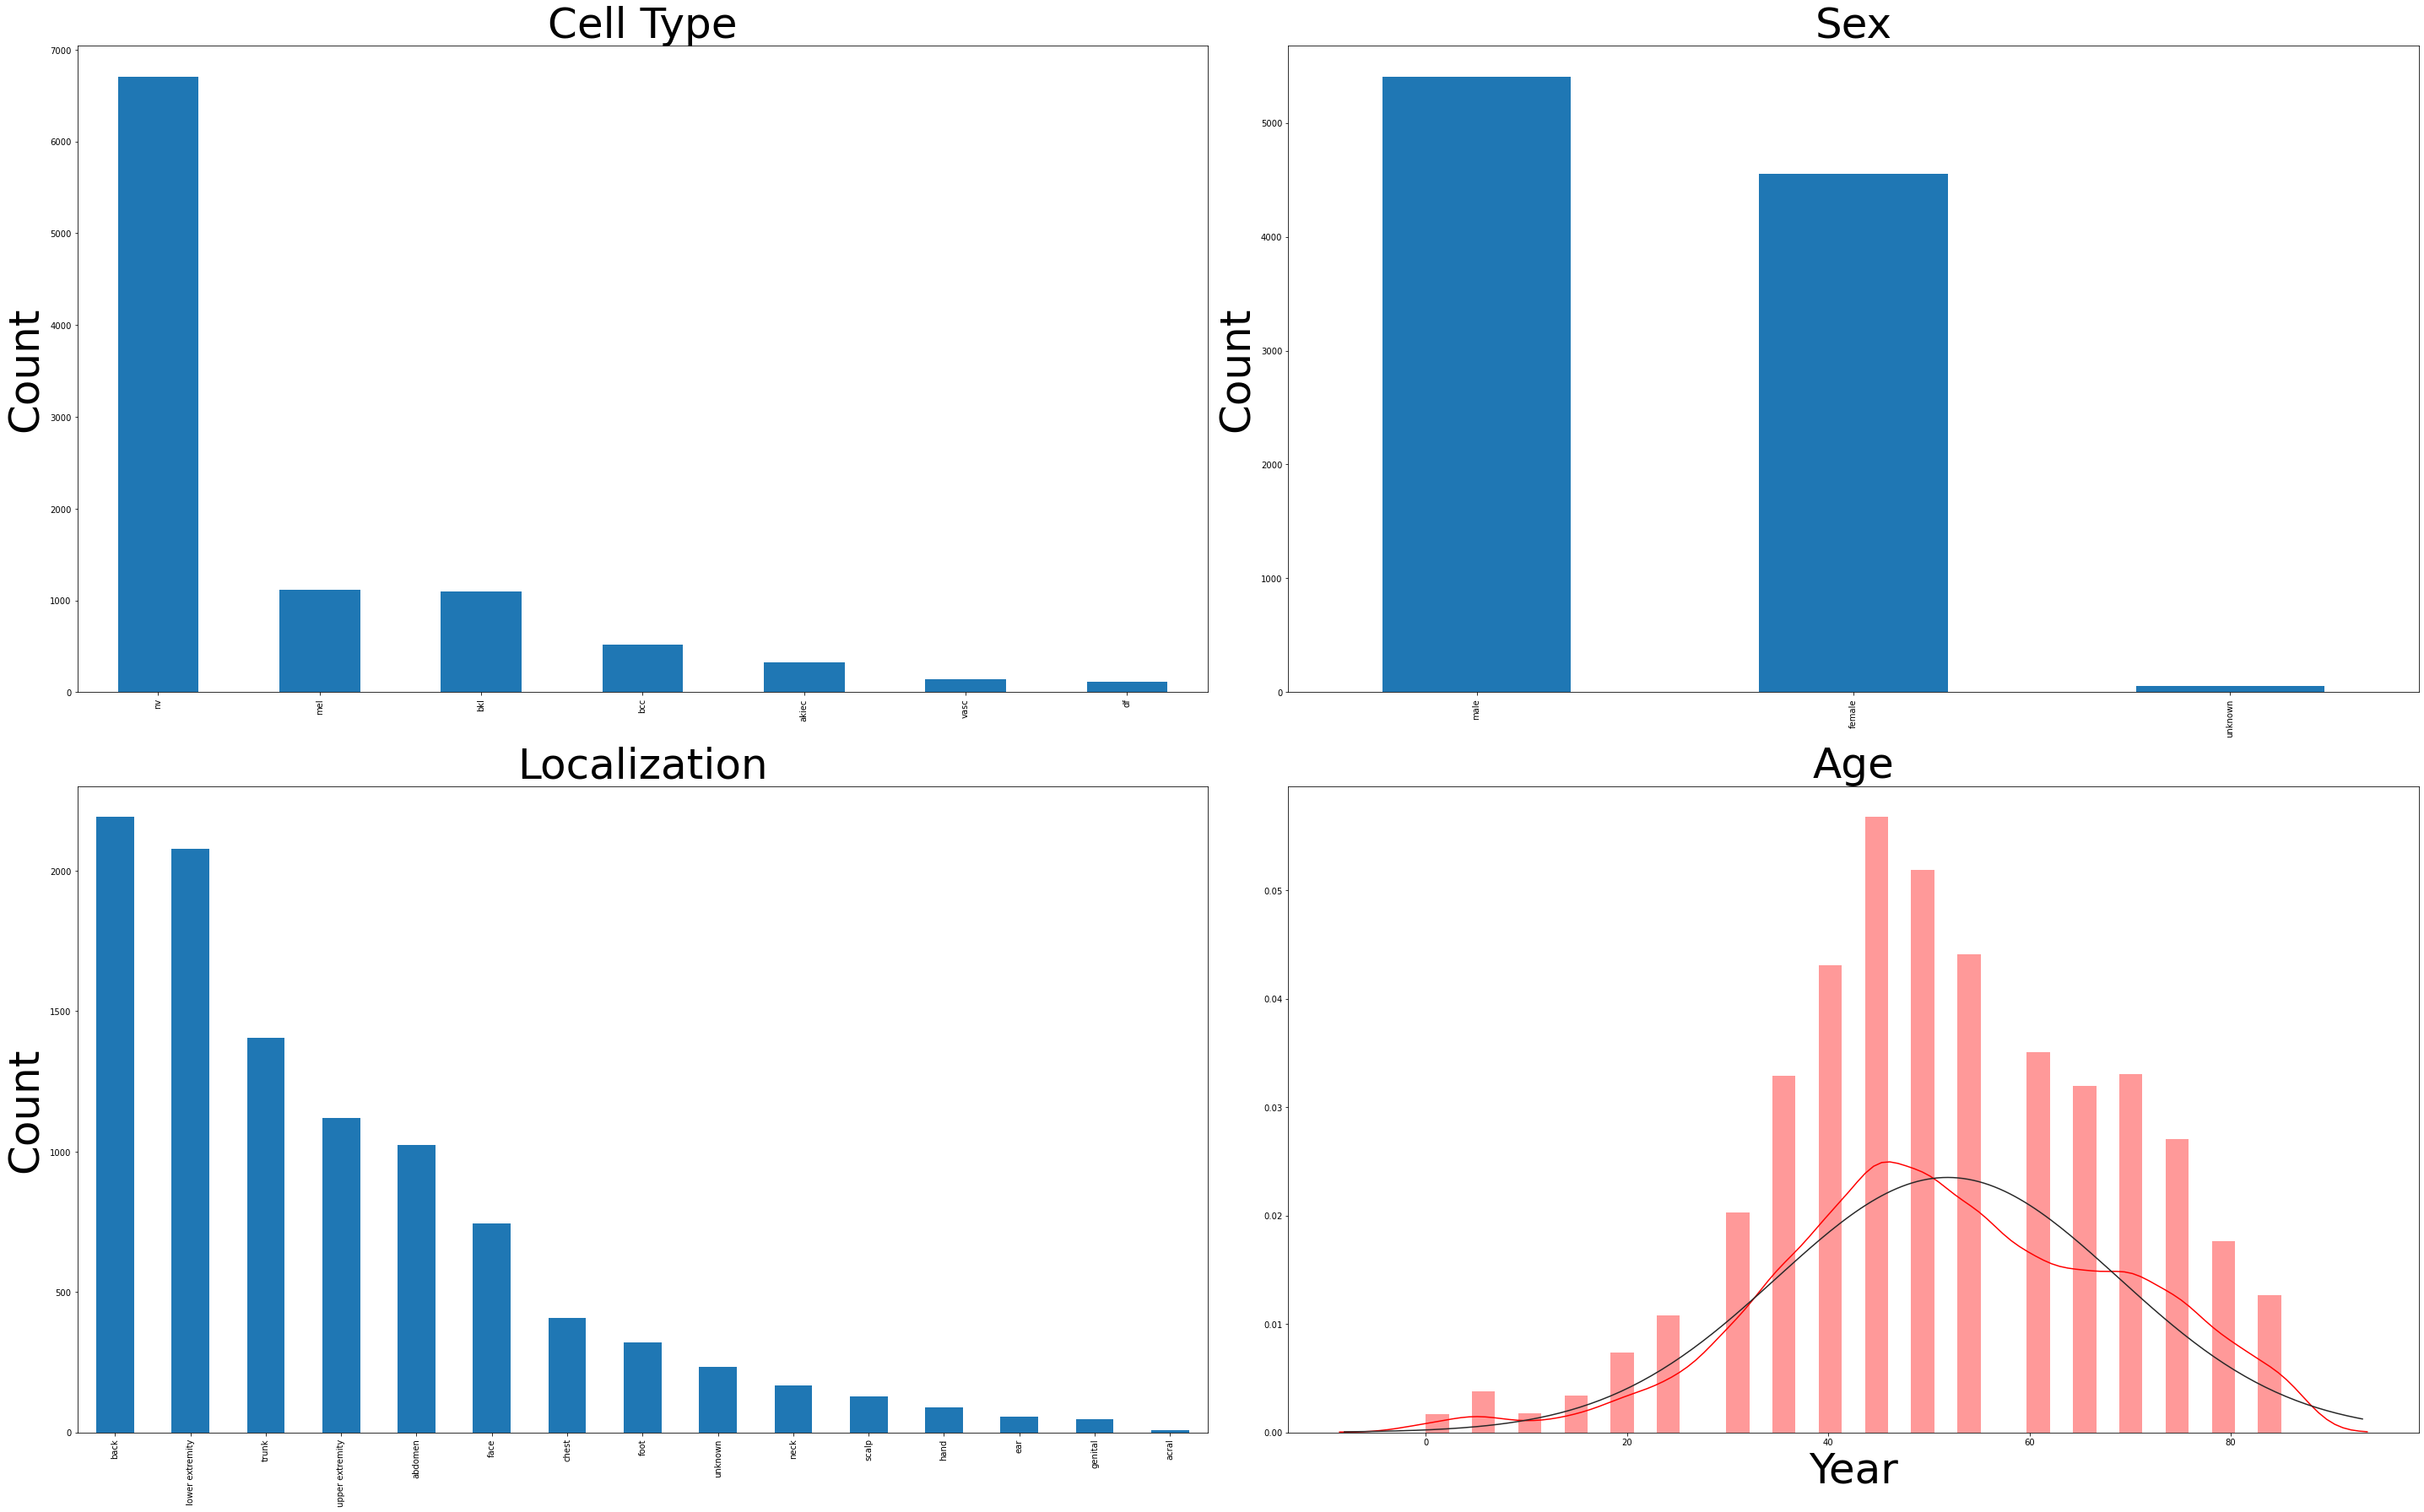

In [28]:

fig = plt.figure(figsize=(40,25))

ax1 = fig.add_subplot(221)
metadata['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count', size=50)
ax1.set_title('Cell Type', size = 50)

ax2 = fig.add_subplot(222)
metadata['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=50)
ax2.set_title('Sex', size=50);

ax3 = fig.add_subplot(223)
metadata['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count', size=50)
ax3.set_title('Localization', size=50)


ax4 = fig.add_subplot(224)
sample_age = metadata[pd.notnull(metadata['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age', size = 50)
ax4.set_xlabel('Year', size=50)

plt.tight_layout()
plt.show()



In [56]:
#Feature importance inference
df = metadata[['dx_type','age','sex','localization','label']]

le = LabelEncoder()
le.fit(df['dx_type'])
df['dx_type'] = le.transform(df["dx_type"]) 

le = LabelEncoder()
le.fit(df['sex'])
df['sex'] = le.transform(df["sex"]) 

le = LabelEncoder()
le.fit(df['localization'])
df['localization'] = le.transform(df["localization"]) 

df = df.dropna()
X = df[['dx_type','age','sex','localization']]
y = df['label']
X

<ipython-input-56-9bcec560db2d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dx_type'] = le.transform(df["dx_type"])
<ipython-input-56-9bcec560db2d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sex'] = le.transform(df["sex"])
<ipython-input-56-9bcec560db2d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

,dx_type,age,sex,localization
0,3,80.0,1,11
1,3,80.0,1,11
2,3,80.0,1,11
3,3,80.0,1,11
4,3,75.0,1,4
...,...,...,...,...
10010,3,40.0,1,0
10011,3,40.0,1,0
10012,3,40.0,1,0
10013,3,80.0,1,5


Feature ranking:
1. feature age (0.375135)
2. feature dx_type (0.349359)
3. feature localization (0.240376)
4. feature sex (0.035131)


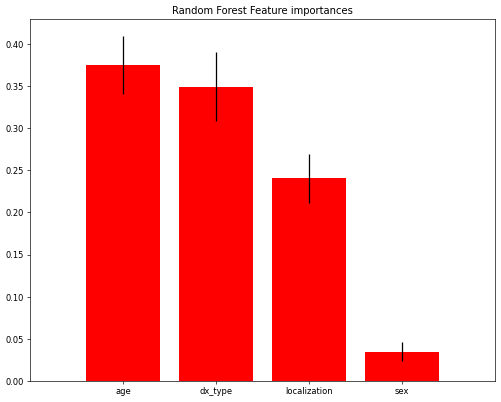

In [76]:
from sklearn.ensemble import RandomForestClassifier
# Build a forest and compute the impurity-based feature importances
forest = RandomForestClassifier(n_estimators=250,
                              random_state=0)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(10, 8), dpi= 60)
plt.title("Random Forest Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices])
plt.xlim([-1, X.shape[1]])
plt.show()

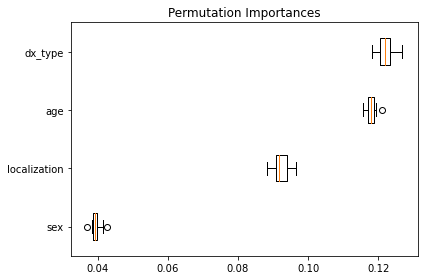

In [77]:
from sklearn.inspection import permutation_importance

result = permutation_importance(forest, X, y, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()